# Bikeshare Data - Exploration and Data Findings Communication
## by Ihab Tag

## Investigation Overview

In any bikeshare project, two of the most important metrics to business are the trip duration and the total trips in a specific period, as they will have direct effects on revenue.
In this investigation, I tried to find out what affects both features in the Boston Bluebikes bikeshare project and what factors may increase or decrease them.

## Dataset Overview

The data set details can be found on the official website at https://www.bluebikes.com/system-data as separate zip files for each year month, I've selected and downloaded the compressed data files for 24 months from Jan, 2018 to Dec, 2019. The original compressed files can be found here https://s3.amazonaws.com/hubway-data/index.html.

I've decompressed the individual files, combined them into one 'csv' file to start working with. A compressed version of it is available here https://www.dropbox.com/s/ztdvsrr67o1y15g/boston_2018_2019.zip?dl=0.

**The data includes:**
    
- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name & ID
- End Station Name & ID
- Bike ID
- User Type (Casual = Single Trip or Day Pass user; Member = Annual or Monthly Member)
- Birth Year
- Gender, self-reported by member

In [94]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [95]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('boston_2018_2019.csv', index_col=0)

In [96]:
#Preliminary data assessment and wrangling

# Dropping unnecessary columns
df = df.drop(columns=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station latitude', 'end station longitude'])

# Dropping rows with null values in 'birth year'
df = df.drop(df[df['birth year'].isnull()].index, axis=0)

# Converting starttime and stoptime columns to type datetime
df[['starttime', 'stoptime']] = df[['starttime', 'stoptime']].apply(pd.to_datetime)

# Converting birth year to int and bikeid to str
df['birth year'] = df['birth year'].astype(int)
df['bikeid'] = df['bikeid'].astype(str)

# Replacing gender values with corresponding gender string
# (Zero=unknown; 1=male; 2=female)
# The values reference is from an identically structured data set avaialble here https://www.citibikenyc.com/system-data

df.loc[df['gender'] == 0, 'gender'] = 'Unknown'
df.loc[df['gender'] == 1, 'gender'] = 'Male'
df.loc[df['gender'] == 2, 'gender'] = 'Female'

# Renaming columns
columns = {
    'tripduration': 'trip_duration',
    'starttime': 'start_time',
    'stoptime': 'end_time', 
    'start station name': 'start_station', 
    'end station name': 'end_station', 
    'bikeid': 'bike_id', 
    'usertype': 'user_type',
    'birth year': 'user_birth_year', 
    'gender': 'gender'
}
df.rename(columns=columns, inplace=True)

In [97]:
# Features engineering

# Adding trip_year column of type int
df['trip_year'] = df.start_time.dt.year.astype(str)

# Adding trip_month column of type str
df['trip_month'] = df.start_time.dt.month_name()

# Adding trip_day column of type str
df['trip_day'] = df.start_time.dt.day_name()

# Adding trip_hour column of type str
df['trip_hour'] = df.start_time.dt.hour.astype(str)

# Adding user_age column of type int which represents the user age at the time of the record
df['user_age'] = df.trip_year.astype(int) - df.user_birth_year

# Creating a clean_df with columns re-arranged for easy interpretation
clean_df = df[['start_time', 'end_time', 
               'trip_year', 'trip_month', 'trip_day', 'trip_hour', 'trip_duration',
               'start_station', 'end_station',
               'bike_id',
               'user_type', 'gender', 'user_age', 'user_birth_year']]

## Growth in total count of trips

Total count of trips grew from 1,662,149 trips in 2018 to 2,412,629 trips in 2019 with about 45% growth rate.

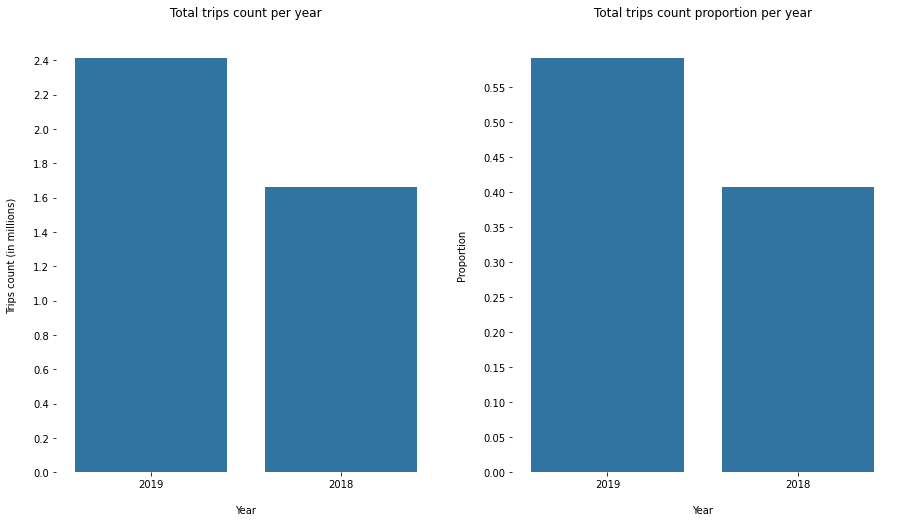

In [98]:
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
# trip_year absolute count
base_color = sb.color_palette()[0]

yticks = np.arange(0, 2.6e6, 2e5)
sb.countplot(data = clean_df, x = 'trip_year', color=base_color);
plt.yticks(yticks, yticks/1e6)
plt.xlabel('\nYear')
plt.ylabel('Trips count (in millions)\n')
plt.title('Total trips count per year\n')
plt.box(False)

plt.subplot(1, 2, 2)
# trip_year proportional
n_points = clean_df.shape[0]
max_count = clean_df.trip_year.value_counts().max()
max_prop = max_count / n_points

tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

sb.countplot(data = clean_df, x = 'trip_year', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('Proportion\n');
plt.xlabel('\nYear');
plt.title('Total trips count proportion per year\n');
plt.box(False);

## Total count of trips distribution over months

Over the months of the year, the total trips count increases gradually starting at January until it peaks at September then gradually decreases again until reaching December.
In general, summer months have the highest trips counts.

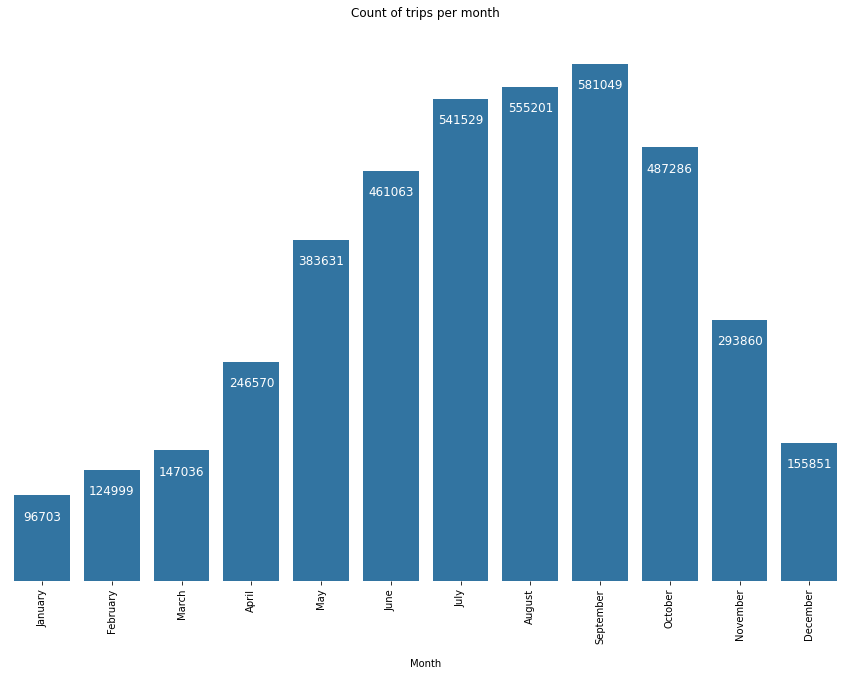

In [99]:
# trip_month
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 'November', 'December']
ordered_months = pd.api.types.CategoricalDtype(ordered = True, categories = months_order)
clean_df.trip_month = clean_df.trip_month.astype(ordered_months)

fig = plt.figure(figsize=(15, 10))
ax = sb.countplot(data = clean_df, x = 'trip_month', color=base_color);
plt.xticks(rotation=90);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)
plt.box(False);
plt.axes().get_yaxis().set_visible(False);
plt.xlabel('\nMonth');
plt.title('Count of trips per month\n');

## Trip duration

After excluding the extreme trips durations, the trips durations range from about 1 minute to about 1.5 hours with average of about 15 minutes.

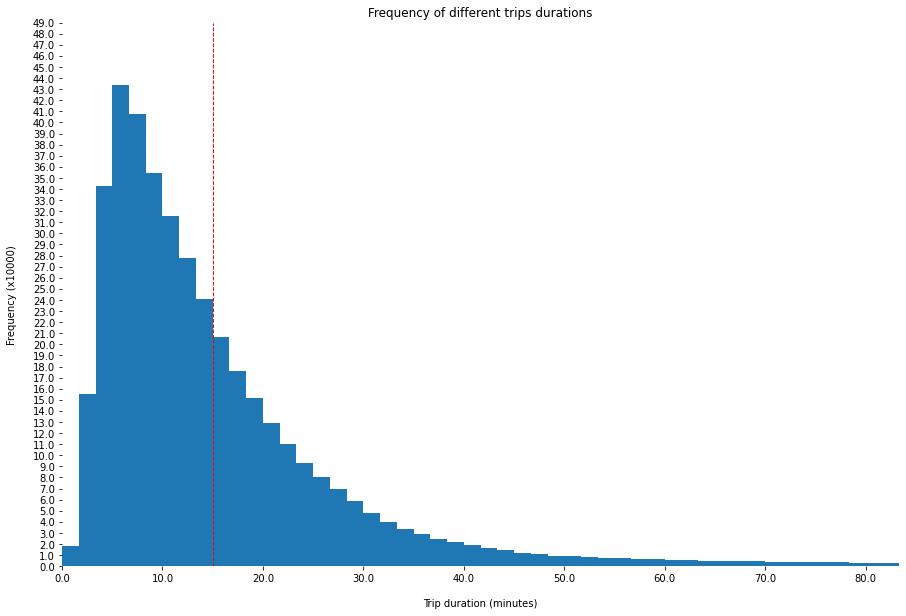

In [109]:
# trip_duration
plt.figure(figsize=(15, 10));
bin_edges = np.arange(0, clean_df.trip_duration.max()+100, 100)

xticks = np.arange(0, 5000, 600)
yticks = np.arange(0, 5e5, 1e4)

plt.hist(data=clean_df, x='trip_duration', bins=bin_edges);
plt.axvline(clean_df[clean_df.trip_duration <= 5000].trip_duration.mean(), color='red', linestyle='dashed', linewidth=1)

plt.xlim(0, 5000);
plt.xlabel('\nTrip duration (minutes)');
plt.ylabel('Frequency (x10000)\n');
plt.xticks(xticks, xticks/60);
plt.yticks(yticks, yticks/1e4);
plt.box(False);
plt.title('Frequency of different trips durations');

## Users classification
Most users belong to the subscriber group, with much more male users than female users in both groups.
Users in the customer group have high tendency not to report their gender.

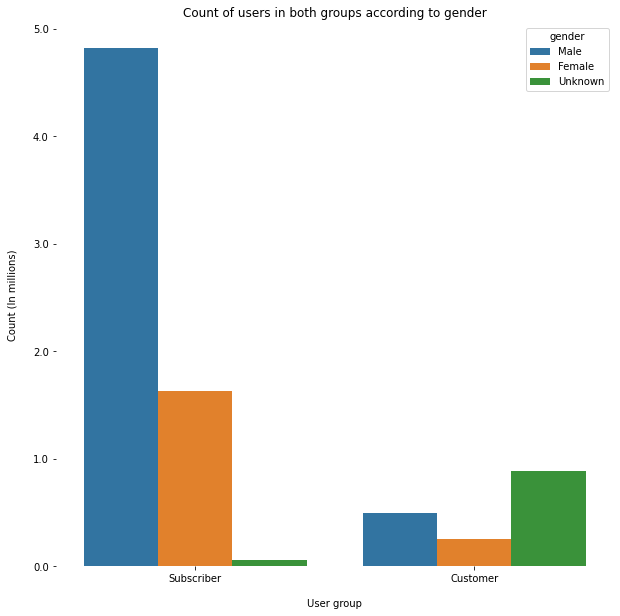

In [110]:
# user_type vs gender
clean_df.gender = pd.Categorical(clean_df.gender, categories=['Male', 'Female', 'Unknown'], ordered=True)
fig = plt.figure(figsize=(10, 10))
ax = sb.countplot(data=clean_df, x='user_type', hue='gender');

yticks = np.arange(0, 3e6, 5e5)

plt.xlabel('\nUser group');
plt.ylabel('Count (In millions)\n');
plt.title('Count of users in both groups according to gender');
plt.yticks(yticks, yticks/5e5);
plt.box(False);

## Trips duration according to users groups and gender
Male users have the smallest trips duration range while users with unknown gender have the largest and females lies in between.
Subscribers have trips with shorter trips durations than customers. 

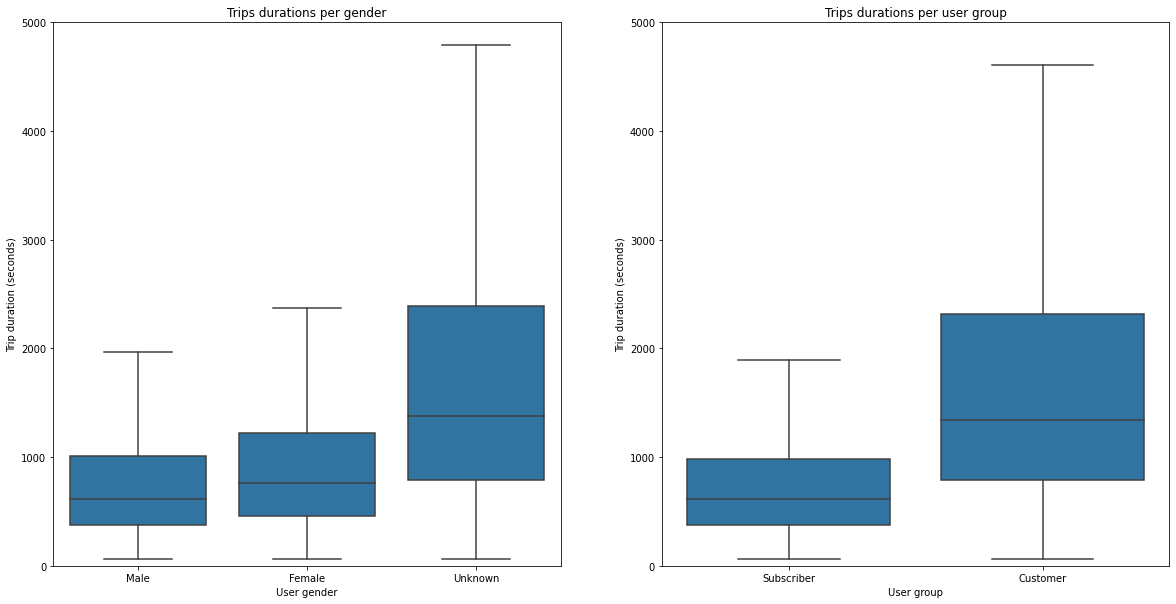

In [102]:
# gender vs trip_duration and user_type vs trip_duration
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
sb.boxplot(data=clean_df, x='gender', y='trip_duration', showfliers = False, color=base_color);
plt.ylim(0, 5000);

plt.xlabel('User gender');
plt.ylabel('Trip duration (seconds)');
plt.title('Trips durations per gender');

plt.subplot(1, 2, 2)
sb.boxplot(data=clean_df, x='user_type', y='trip_duration', showfliers = False, color=base_color);
plt.ylim(0, 5000);
plt.xlabel('User group');
plt.ylabel('Trip duration (seconds)');
plt.title('Trips durations per user group');


## Most active hours in week days

In normal days of the week, the most active hours are early morning "go to work" around 08:00 AM and evening "back to home" hours around 05:00 PM, while in weekends, the most active hours are from late morning at 10:00 AM to evening at 07:00 PM.

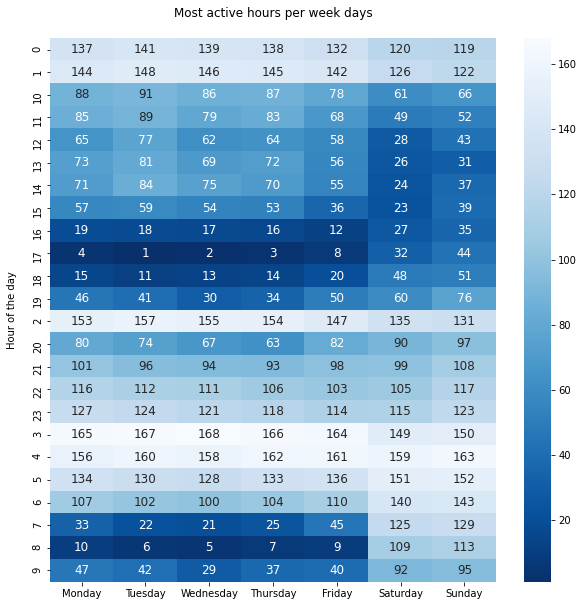

In [111]:
# trip_hour vs trip_day
# The main idea of converting categorical variables to numerical ranks for easy plotting as a heatmap was adopted from similar plot at https://github.com/juliaYi/Ford-GoBike-Data-Visualization/blob/master/ford_bike_data_analysis.ipynb
trip_hour_day = clean_df.groupby(['trip_hour', 'trip_day']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
trip_hour_day.trip_day = pd.Categorical(trip_hour_day.trip_day, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
trip_hour_day['percent'] = trip_hour_day['count'].apply(lambda x: (x/trip_hour_day['count'].sum())*100)
trip_hour_day['rank'] = trip_hour_day['percent'].rank(ascending=False).astype(int)
trip_hour_day_pivoted = trip_hour_day.pivot_table(index='trip_hour', columns='trip_day', values='rank')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([.125, .125, .775, .755])
sb.heatmap(trip_hour_day_pivoted, fmt='d', annot=True, cmap='Blues_r', annot_kws={"size": 12});
plt.title('Most active hours per week days\n');
plt.xlabel('');
plt.ylabel('Hour of the day\n');

## Correlation between user age and trip duration

There is a positive correlation between user age and trip duration.
Specifically users around age of 50 tend to have longer trips durations than other ages.

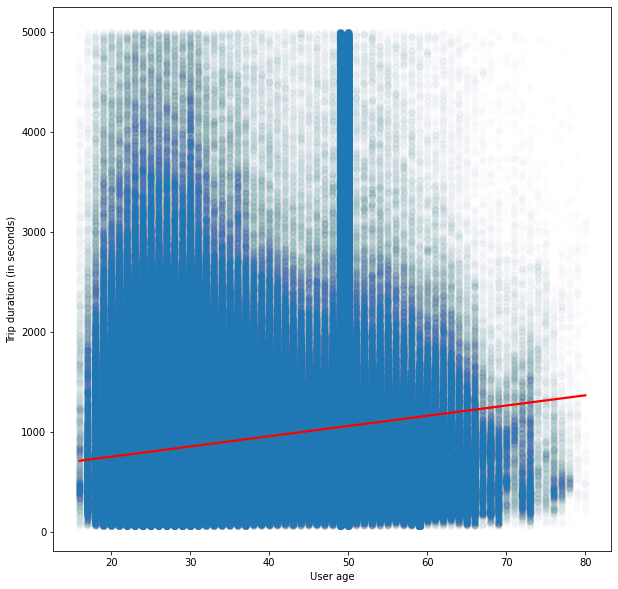

In [114]:
# user_age vs trip_duration

trimmed_df = clean_df[(clean_df.user_age <= 80) & (clean_df.trip_duration <= 5000)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([.125, .125, .775, .755])
sb.regplot(data=trimmed_df, x='user_age', y='trip_duration', scatter_kws={'alpha':0.006, }, line_kws={"color": "red"}, x_jitter=0.1);
plt.xlabel('User age');
plt.ylabel('Trip duration (in seconds)');

## Users age distribution over months for different user groups

While there is a consistency in the median and ranges of age of the subscriber group in different months with median lies around age of 30, the customer group has higher medians and wider ranges with medians lies around 50 years old in all months except November which lies nearly at 40 years old.

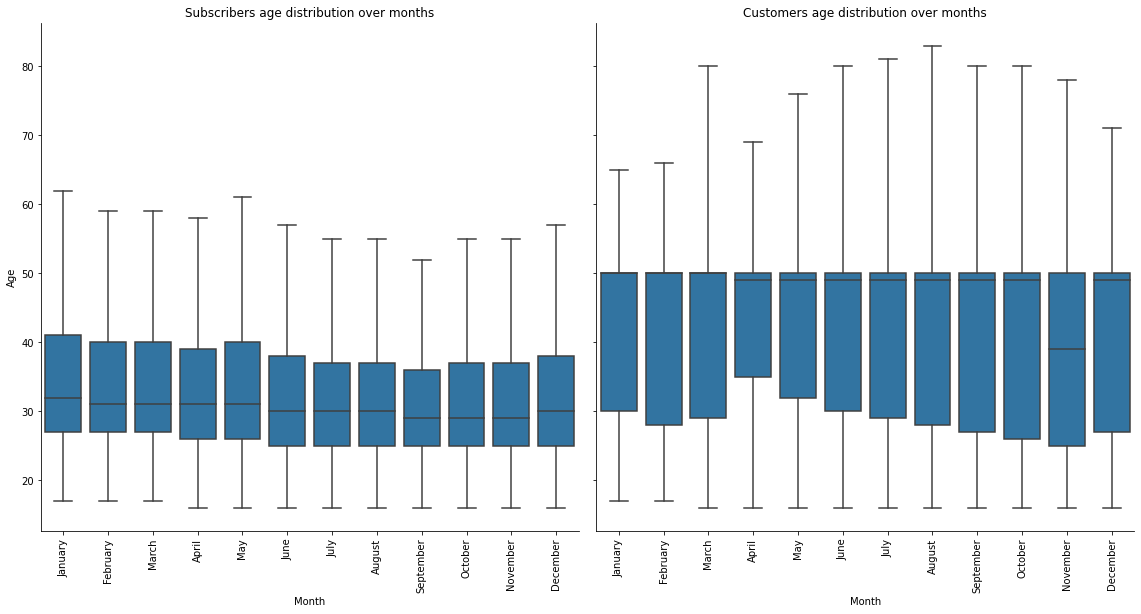

In [105]:
# user_type vs trip_month vs user_age
g = sb.FacetGrid(data = clean_df, col = 'user_type', size=8);
g.map(sb.boxplot, 'trip_month', 'user_age', showfliers = False);
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
g.axes[0,0].set_xlabel('Month');
g.axes[0,1].set_xlabel('Month');

g.axes[0,0].set_ylabel('Age');

g.axes[0,0].set_title('Subscribers age distribution over months');
g.axes[0,1].set_title('Customers age distribution over months');

## Trips duration distribution over months for different user groups

Users in subscriber group tend to have consistent trip durations over months, but in the customer group there is some variability in the trip durations from month to month with wider range and higher values.

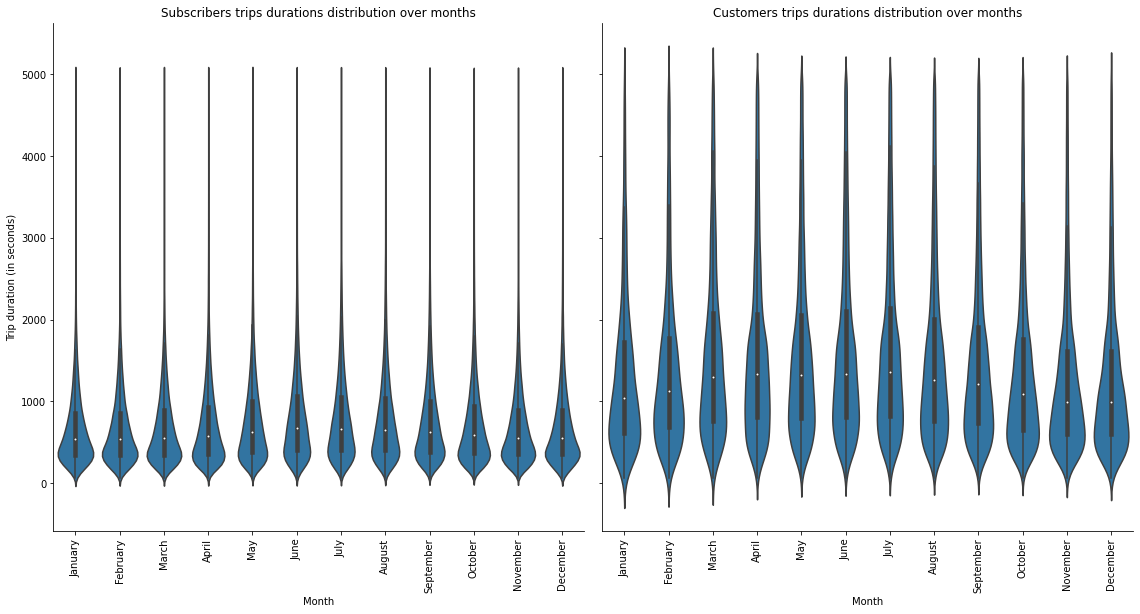

In [106]:
# user_type vs trip_month vs trip_duration

trimmed_duration_df = clean_df[clean_df.trip_duration <= 5000]

g = sb.FacetGrid(data = trimmed_duration_df, col = 'user_type', size=8);
g.map(sb.violinplot, 'trip_month', 'trip_duration');
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
g.axes[0,0].set_xlabel('Month');
g.axes[0,1].set_xlabel('Month');

g.axes[0,0].set_ylabel('Trip duration (in seconds)');

g.axes[0,0].set_title('Subscribers trips durations distribution over months');
g.axes[0,1].set_title('Customers trips durations distribution over months');

## Conclusions

There was a significant growth of 45% for total trips from 2018 to 2019, most of trips came from subscribers group who have both lower average trip duration and lower mean age than the users in the customer group who tend to be around the age of 50 with longer trips duration.

Male user dominates both groups, but in the customers group, users who didn't report their gender were larger than both genders in the same group.

In normal days of the week, the most active hours are early morning "go to work" around 08:00 AM and evening "back to home" hours around 05:00 PM, while in weekends, the most active hours are from late morning at 10:00 AM to evening at 07:00 PM.